## Imports

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import logging

import matplotlib.pyplot as plt
import pandas as pd

import core.explore as coexplor
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im.ib.data.extract.gateway.utils as imidegaut
import im.kibot as vakibot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

# Packages
         python: 3.7.6
       gluonnlp: 0.9.1
        gluonts: 0.5.0
         joblib: 0.15.1
          mxnet: 1.6.0
          numpy: 1.19.2
         pandas: 1.0.5
        pyarrow: 0.17.1
          scipy: 1.4.1
        seaborn: 0.10.1
        sklearn: 0.23.1
    statsmodels: 0.11.1
# Last commits:
  * e687bc2 saggese  Checkpoint                                                        (  19 hours ago) Mon Feb 22 20:51:30 2021  (HEAD -> Task109_Extract_futures_prices_from_dockerized_TWS_02, origin/Task109_Extract_futures_prices_from_dockerized_TWS_02)
  * ac22dd2 saggese  Re-establish sanity: unit tests passing                           (  19 hours ago) Mon Feb 22 20:40:26 2021           
  * 92543a9 saggese  Parallelize the download                                          (    2 days ago) Sun Feb 21 21:04:33 2021           


In [4]:
def get_min_max_from_index(df):
    min_dt = min(df.index)
    max_dt = max(df.index)
    if True:
        min_dt = str(pd.Timestamp(min_dt).date())
        max_dt = str(pd.Timestamp(max_dt).date())
    print("min=", min_dt)
    print("max=", max_dt)
    return min_dt, max_dt


def print_df(df, n=3):
    print("shape=", df.shape)
    display(df.head(n))
    display(df.tail(n))

# Kibot

In [5]:
df_kibot = vakibot.KibotS3DataLoader().read_data(
    "Kibot",
    "ES",
    vakibot.AssetClass.Futures,
    vakibot.Frequency.Minutely,
    vakibot.ContractType.Continuous,
)
df_kibot.head()
df_kibot_orig = df_kibot.copy()

Found credentials in shared credentials file: ~/.aws/credentials
Found credentials in shared credentials file: ~/.aws/credentials


In [6]:
df_kibot = df_kibot_orig.copy()
df_kibot.rename({"vol": "volume"}, axis=1, inplace=True)
# df_kibot.index = pd.to_datetime(df_kibot.index, utc=True).tz_convert(tz='America/New_York')
df_kibot.index = pd.to_datetime(df_kibot.index).tz_localize(tz="America/New_York")

print_df(df_kibot, n=2)

shape= (3413857, 5)


,open,high,low,close,volume
datetime,,,,,
2009-09-27 18:00:00-04:00,1042.25,1043.25,1042.25,1043.00,1354
2009-09-27 18:01:00-04:00,1043.25,1043.50,1042.75,1042.75,778


,open,high,low,close,volume
datetime,,,,,
2019-07-19 16:58:00-04:00,2972.25,2972.50,2971.5,2971.5,458
2019-07-19 16:59:00-04:00,2971.75,2971.75,2969.5,2971.0,2338


2019-05-27 00:00:00 Monday
2019-05-30 00:00:00 Thursday
samples=4321 [2019-05-27 00:00:00-04:00, 2019-05-30 00:00:00-04:00]
2019-05-27 Monday
2019-05-28 Tuesday
2019-05-29 Wednesday
2019-05-30 Thursday
samples=4321 [2019-05-27 00:00:00-04:00, 2019-05-30 00:00:00-04:00]
datetime
2019-05-27 00:35:00-04:00    False
2019-05-27 00:43:00-04:00    False
2019-05-27 07:25:00-04:00    False
2019-05-27 13:00:00-04:00    False
2019-05-27 13:01:00-04:00    False
Name: volume, dtype: bool
no support= 454
with support= 3867


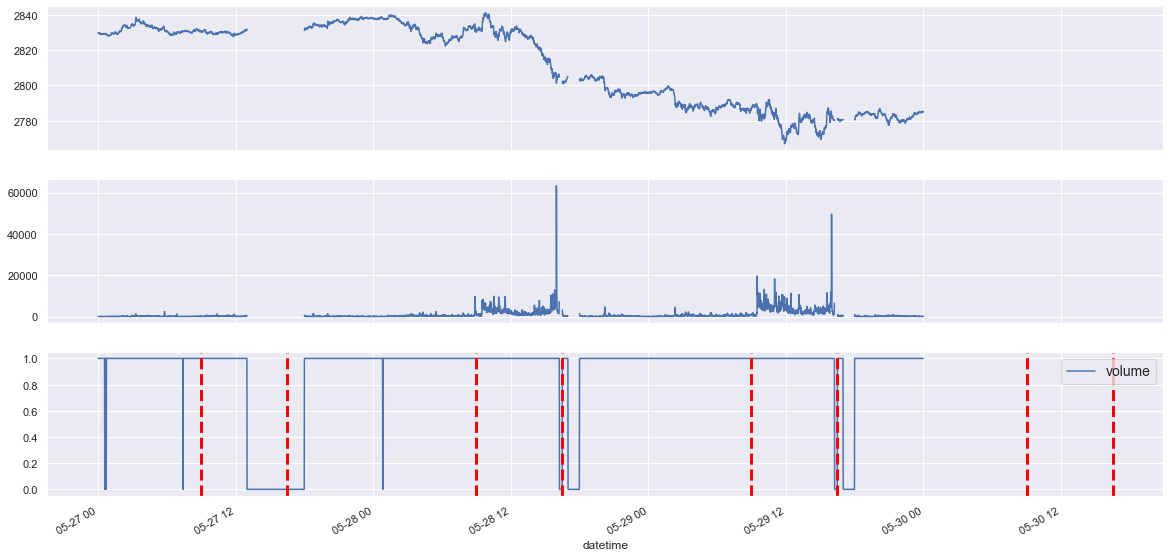

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, sharex=True, figsize=(20, 10)
)

df_tmp = df_kibot.resample("1T").mean()

a = pd.Timestamp("2019-05-27 00:00:00")
# a = pd.Timestamp("2019-05-29 00:00:00")
# a = pd.Timestamp("2019-06-02 00:00:00")
print(a, a.day_name())

# b = a + pd.DateOffset(14)
# b = a + pd.DateOffset(7)
b = a + pd.DateOffset(3)
# b = a + pd.DateOffset(1)
print(b, b.day_name())

df_tmp = df_tmp[a:b][["close", "volume"]]
print(
    "samples=%d [%s, %s]" % (df_tmp.shape[0], df_tmp.index[0], df_tmp.index[-1])
)

dates = sorted(list(set(df_tmp.index.date)))  # .unique()
for date in dates:
    print(date, pd.Timestamp(date).day_name())

df_tmp = df_tmp.resample("1T").mean()
df_tmp["close"].plot(ax=ax1)
df_tmp["volume"].plot(ax=ax2)
print(
    "samples=%d [%s, %s]" % (df_tmp.shape[0], df_tmp.index[0], df_tmp.index[-1])
)

#
# df_tmp2 = df_tmp.resample("1T").mean()
# print("samples=%d [%s, %s]" % (df_tmp2.shape[0], df_tmp2.index[0], df_tmp2.index[-1]))

# support = ~pd.isnull(df_tmp["close"])
support = ~pd.isnull(df_tmp["volume"])
print(support[~support].head())
print("no support=", (~support[~support]).sum())
print("with support=", support[support].sum())
pd.DataFrame(1.0 * support).plot(ax=ax3)

for date in dates:
    for h, m in ((9, 0), (16, 30)):
        date_tmp = datetime.datetime.combine(date, datetime.time(h, m))
        date_tmp = pd.Timestamp(date_tmp).tz_localize(tz="America/New_York")
        plt.axvline(date_tmp, color="red", linestyle="--", linewidth=3)

# IB

In [8]:
import ib_insync

ib = imidegaut.ib_connect(1)

Connecting to 127.0.0.1:7497 with clientId 1...
Connected
Logged on to server version 152
API connection ready
Warning 2104, reqId -1: Market data farm connection is OK:usfarm.nj
Warning 2104, reqId -1: Market data farm connection is OK:eufarm
Warning 2104, reqId -1: Market data farm connection is OK:usfuture
Warning 2104, reqId -1: Market data farm connection is OK:cashfarm
Warning 2104, reqId -1: Market data farm connection is OK:usfarm
Warning 2106, reqId -1: HMDS data farm connection is OK:ushmds
Warning 2158, reqId -1: Sec-def data farm connection is OK:secdefil
Synchronization complete


In [9]:
contract = ib_insync.ContFuture("ES", "GLOBEX", "USD")
whatToShow = "TRADES"
barSizeSetting = "1 min"
# barSizeSetting = '1 hour'
useRTH = False

start_ts = pd.Timestamp("2019-05-28 15:00").tz_localize(tz="America/New_York")
end_ts = pd.Timestamp("2019-05-29 15:00").tz_localize(tz="America/New_York")

# file_name = "ES.csv"
# if os.path.exists(file_name):
# df_ib = imidegaut.get_data(ib, contract, start_ts, end_ts, barSizeSetting, whatToShow, useRTH)
# df_ib.to_csv("ES.csv")

durationStr = "1 D"
df_ib = imidegaut.req_historical_data(
    ib, contract, end_ts, durationStr, barSizeSetting, whatToShow, useRTH
)

In [10]:
display(df_ib.head(2))
print(df_ib.index[0], df_ib.index[-1])

display(df_kibot.head(2))
print(df_kibot.index[0], df_kibot.index[-1])

,open,high,low,close,volume,average,barCount
date,,,,,,,
2019-05-28 18:00:00-04:00,2804.25,2805.25,2802.25,2803.5,1398,2803.700,322
2019-05-28 18:01:00-04:00,2803.50,2804.00,2803.25,2803.5,322,2803.725,86


2019-05-28 18:00:00-04:00 2019-05-29 14:59:00-04:00


,open,high,low,close,volume
datetime,,,,,
2009-09-27 18:00:00-04:00,1042.25,1043.25,1042.25,1043.00,1354
2009-09-27 18:01:00-04:00,1043.25,1043.50,1042.75,1042.75,778


2009-09-27 18:00:00-04:00 2019-07-19 16:59:00-04:00


# Compare

In [11]:
target_col = "close"
# target_col = "open"
# target_col = "high"
# target_col = "volume"

In [12]:
if True:
    print_df(df_ib, n=1)
    print_df(df_kibot, n=1)

shape= (1260, 7)


,open,high,low,close,volume,average,barCount
date,,,,,,,
2019-05-28 18:00:00-04:00,2804.25,2805.25,2802.25,2803.5,1398,2803.7,322


,open,high,low,close,volume,average,barCount
date,,,,,,,
2019-05-29 14:59:00-04:00,2774.0,2774.5,2773.75,2774.25,1611,2774.125,212


shape= (3413857, 5)


,open,high,low,close,volume
datetime,,,,,
2009-09-27 18:00:00-04:00,1042.25,1043.25,1042.25,1043.0,1354


,open,high,low,close,volume
datetime,,,,,
2019-07-19 16:59:00-04:00,2971.75,2971.75,2969.5,2971.0,2338


In [13]:
# min_dt = "2013-10-06"
# max_dt = "2013-10-09"
min_dt = start_ts
max_dt = end_ts

#
df_ib_tmp = df_ib.loc[min_dt:max_dt]
df_ib_tmp.columns = ["%s_ib" % c for c in df_ib_tmp.columns]
df_ib_tmp.head()
#
df_kibot_tmp = df_kibot.loc[min_dt:max_dt]
df_kibot_tmp.columns = ["%s_kibot" % c for c in df_kibot_tmp.columns]
df_kibot_tmp.head()

# df = pd.concat([df_ib_tmp, df_kibot_tmp], axis=1, join="outer")
df = pd.concat([df_ib_tmp, df_kibot_tmp], axis=1, join="inner")
display(df.head(1))

# Shift.
df["%s_ib" % target_col] = df["%s_ib" % target_col].shift(0)

# Filter columns.
display(df[cols].head(10))
cols = ["%s_%s" % (target_col, src) for src in "ib kibot".split()]
df[cols].plot()

,open_ib,high_ib,low_ib,close_ib,volume_ib,average_ib,barCount_ib,open_kibot,high_kibot,low_kibot,close_kibot,volume_kibot
2019-05-28 18:00:00-04:00,2804.25,2805.25,2802.25,2803.5,1398,2803.7,322,2804.25,2805.25,2802.25,2803.5,1398


NameError: name 'cols' is not defined

In [ ]:
df.iloc[:100][cols].plot()

In [ ]:
ds1 = "ib"
ds2 = "kibot"
diff = df[target_col + "_" + ds1] - df[target_col + "_" + ds2]

diff.plot()

hpandas.dropna(pd.DataFrame(diff), drop_infs=True).hist(bins=101)

In [ ]:
intercept = False
coexplor.ols_regress(
    df,
    target_col + "_" + ds1,
    target_col + "_" + ds2,
    intercept,
    jointplot_=True,
    max_nrows=None,
)

Warning 2103, reqId -1: Market data farm connection is broken:cashfarm
Warning 2103, reqId -1: Market data farm connection is broken:cashfarm
Warning 2103, reqId -1: Market data farm connection is broken:cashfarm
Warning 2103, reqId -1: Market data farm connection is broken:cashfarm
Warning 2103, reqId -1: Market data farm connection is broken:cashfarm
Warning 2104, reqId -1: Market data farm connection is OK:cashfarm
Warning 2103, reqId -1: Market data farm connection is broken:cashfarm
Warning 2104, reqId -1: Market data farm connection is OK:cashfarm
Warning 2103, reqId -1: Market data farm connection is broken:usfuture
Warning 2104, reqId -1: Market data farm connection is OK:usfuture
Warning 2103, reqId -1: Market data farm connection is broken:usfuture
Warning 2104, reqId -1: Market data farm connection is OK:usfuture
